In [89]:
import torch
import torch.nn as nn
import nussl
from nussl.datasets import transforms as nussl_tfm
from nussl.ml.networks.modules import BatchNorm, RecurrentStack, Embedding, STFT, LearnedFilterBank, AmplitudeToDB
from models.MaskInference import MaskInference
from models.UNet import UNetSpect
from models.Filterbank import Filterbank
from utils import utils, data, viz
from pathlib import Path
import yaml, argparse
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [90]:
#Load yaml configs into configs dictionary
with open('config/test_fb_4sources.yml','r') as f:
    configs = yaml.safe_load(f)
    f.close()

In [45]:
utils.logger()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_type = configs['model_type']
model_dict = {'Mask': MaskInference,
              'UNet': UNetSpect,
              'Filterbank':Filterbank
             }
waveform_models = ['Filterbank']
assert model_type in model_dict.keys(), f'Model type must be one of {model_dict.keys()}'

if model_type in waveform_models:
    stft_params = None
    
    tfm = nussl_tfm.Compose([
        #nussl_tfm.SumSources([['bass', 'drums', 'other']]),
        nussl_tfm.GetAudio(),
        #nussl_tfm.IndexSources('source_audio', 1),
        nussl_tfm.ToSeparationModel(),
    ])
    
    target_key = 'source_audio'
    output_key = 'audio'
    
else:
    stft_params = nussl.STFTParams(**configs['stft_params'])
    
    tfm = nussl_tfm.Compose([
        #nussl_tfm.SumSources([['bass', 'drums', 'other']]),
        nussl_tfm.MagnitudeSpectrumApproximation(),
        #nussl_tfm.IndexSources('source_magnitudes', 1),
        nussl_tfm.ToSeparationModel(),
    ])
    
    target_key = 'source_magnitudes'
    output_key = 'estimates'


configs['batch_size'] = 1
configs['train_generator_params']['num_mixtures']=10
configs['valid_generator_params']['num_mixtures']=1

duration=5

train_data = data.on_the_fly(stft_params, transform=tfm, fg_path=configs['test_folder'], **configs['train_generator_params'], duration=duration)
train_dataloader = torch.utils.data.DataLoader(train_data, num_workers=1, batch_size=configs['batch_size'])

val_data = data.on_the_fly(stft_params, transform=tfm, fg_path=configs['test_folder'], **configs['valid_generator_params'], duration=duration)
val_dataloader = torch.utils.data.DataLoader(val_data, num_workers=1, batch_size=configs['batch_size'])

In [46]:
overfit_selection=1

In [47]:
loss_type = configs['loss_type']
loss_dict = {'L1': nussl.ml.train.loss.L1Loss,
             'L2': nussl.ml.train.loss.MSELoss,
             'MSE': nussl.ml.train.loss.MSELoss,}
assert loss_type in loss_dict.keys(), f'Loss type must be one of {loss_dict.keys()}'
loss_fn = loss_dict[loss_type]()

In [48]:
def train_step(engine, batch):
    optimizer.zero_grad()
    
    #Forward pass
    output = model(batch)
    loss = loss_fn(output[output_key],batch[target_key])
    
    #Backward pass
    loss.backward()
    optimizer.step()
    
    loss_vals = {'loss':loss.item()}
    
    return loss_vals

def val_step(engine, batch):
    with torch.no_grad():
        output = model(batch)
    loss = loss_fn(output[output_key],batch[target_key])  
    loss_vals = {'loss':loss.item()}
    return loss_vals

In [49]:
#Set up the model and optimizer
if model_type=='Mask':
    model = MaskInference.build(stft_params.window_length//2+1, **configs['model_params']).to(device)
elif model_type=='UNet':
    model = UNetSpect.build(**configs['model_params']).to(device)
elif model_type=='Filterbank':
    model = Filterbank.build(**configs['model_params']).to(device)

optimizer = torch.optim.Adam(model.parameters(), **configs['optimizer_params'])

In [50]:
model

SeparationModel(
  (layers): ModuleDict(
    (model): MaskInference(
      (amplitude_to_db): AmplitudeToDB()
      (input_normalization): BatchNorm(
        (batch_norm): BatchNorm1d(257, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (recurrent_stack): RecurrentStack(
        (rnn): LSTM(257, 64, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
      )
      (embedding): Embedding(
        (linear): Linear(in_features=128, out_features=1028, bias=True)
      )
    )
    (mask): Alias()
    (estimates): Alias()
  )
)
Number of parameters: 397830

In [51]:
for i,batch in enumerate(train_dataloader):
    if i==overfit_selection:
        batch=batch
        break
    
for key in batch:
    if torch.is_tensor(batch[key]):
        batch[key] = batch[key].float().to(device)   

In [52]:
configs['optimizer_params']['lr'] = 1e-2
optimizer = torch.optim.Adam(model.parameters(), **configs['optimizer_params'])

In [53]:
# Create nussl ML engine
trainer, validator = nussl.ml.train.create_train_and_validation_engines(train_step, val_step, device=device)

In [55]:
# output = model(batch)
# x = batch['mix_magnitude']
# x = model.layers.model.amplitude_to_db(x)
# x = model.layers.model.input_normalization(x)
# x = model.layers.model.recurrent_stack(x)
# x = model.layers.model.embedding(x)

In [58]:
N_ITERATIONS = 200
loss_history = [] # For bookkeeping

for i in range(N_ITERATIONS):
    loss_val = train_step(trainer,batch)
    loss_history.append(loss_val['loss'])
    if i%20==0:
        print(f'Loss: {loss_val["loss"]:.6f} at iteration {i}')

Loss: 0.000908 at iteration 0
Loss: 0.000236 at iteration 20
Loss: 0.000184 at iteration 40
Loss: 0.000159 at iteration 60
Loss: 0.000143 at iteration 80
Loss: 0.000133 at iteration 100
Loss: 0.000126 at iteration 120
Loss: 0.000122 at iteration 140
Loss: 0.000119 at iteration 160
Loss: 0.000116 at iteration 180


In [61]:
configs['train_params']['epoch_length']=2
configs['train_params']['max_epochs']=1
configs['optimizer_params']['lr'] = 1e-10
optimizer = torch.optim.Adam(model.parameters(), **configs['optimizer_params'])

# Save model outputs
checkpoint_folder = Path('overfit').absolute()

# Adding handlers from nussl that print out details about model training
# run the validation step, and save the models.
nussl.ml.train.add_stdout_handler(trainer, validator)
nussl.ml.train.add_validate_and_checkpoint(checkpoint_folder, model, optimizer, train_data, trainer, val_dataloader, validator)
nussl.ml.train.add_progress_bar_handler(trainer, validator)

In [62]:
trainer.run(train_dataloader, **configs['train_params'])

04/28/2023 09:09:55 AM | engine.py:874 Engine run starting with max_epochs=1.
Iteration: [1/2]  50%|█████████████████████████████████████████████████████████████▌                                                             , avg_loss=0.000796 [00:00<?]
[1/2]  50%|████████████████████████████████████████████████████████████████████████████▌                                                                             [00:00<?]
Iteration: [1/2]  50%|███████████████████████████████████████████████████████████████████████                                                                        [00:00<?]
Iteration: [1/2]  50%|█████████████████████████████████████████████████████████████▌                                                             , avg_loss=0.000796 [00:00<?]

[1/2]  50%|████████████████████████████████████████████████████████████████████████████▌                                                                             [00:00<?]

Iteration: [1/2]  50%|███████████████████████

State:
	iteration: 2
	epoch: 1
	epoch_length: 2
	max_epochs: 1
	output: <class 'dict'>
	batch: <class 'dict'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>
	epoch_history: <class 'dict'>
	iter_history: <class 'dict'>
	past_iter_history: <class 'dict'>
	saved_model_path: /SFS/user/ry/stonekev/audio/audio_isolation/overfit/checkpoints/latest.model.pth
	output_folder: <class 'pathlib.PosixPath'>

In [63]:
target = batch[target_key].detach().numpy()
output = model(batch)
estimates = output[output_key].detach().numpy()

In [64]:
print(np.max(target))
print(np.max(estimates))
print(np.min(target))
print(np.min(estimates))
print(np.std(target))
print(np.std(estimates))

0.3046187
0.30080077
0.0
2.730985e-11
0.004129545
0.0039819907


In [65]:
#Load in the model
if model_type in waveform_models:
    separator = nussl.separation.deep.DeepAudioEstimation(
        nussl.AudioSignal(), model_path='overfit/checkpoints/latest.model.pth',
        device='cpu',
    )
else:
    separator = nussl.separation.deep.DeepMaskEstimation(
        nussl.AudioSignal(), model_path='overfit/checkpoints/latest.model.pth',
        device='cpu',
    )

/SFS/user/ry/stonekev/miniconda3/envs/audio/lib/python3.10/site-packages/nussl/separation/base/separation_base.py:73: UserWarning: input_audio_signal has no data!
  warnings.warn('input_audio_signal has no data!')
/SFS/user/ry/stonekev/miniconda3/envs/audio/lib/python3.10/site-packages/nussl/core/audio_signal.py:455: UserWarning: Initializing STFT with data that is non-complex. This might lead to weird results!
  warnings.warn('Initializing STFT with data that is non-complex. '


In [75]:
#Test on the data
test_folder = configs['test_folder']
tfm = None
test_data = data.on_the_fly(stft_params, transform=None, fg_path=configs['test_folder'], **configs['train_generator_params'], duration=duration)

signal = test_data[overfit_selection]['mix']

In [76]:
test_data[overfit_selection]

{'mix': <nussl.core.audio_signal.AudioSignal at 0x7f28e03c7ca0>,
 'sources': {'vocals': <nussl.core.audio_signal.AudioSignal at 0x7f28e03e22c0>,
  'drums': <nussl.core.audio_signal.AudioSignal at 0x7f28e03e3be0>,
  'bass': <nussl.core.audio_signal.AudioSignal at 0x7f28e03e3df0>,
  'other': <nussl.core.audio_signal.AudioSignal at 0x7f28e03e3340>},
 'metadata': {'jam': <JAMS(file_metadata=<FileMetadata(...)>,
        annotations=[1 annotation],
        sandbox=<Sandbox(...)>)>,
  'idx': 1}}

In [85]:
ground_truth = []
correct_order = ['bass','drums','other','vocals']
for source in correct_order:
    ground_truth.append(test_data[overfit_selection]['sources'][source])

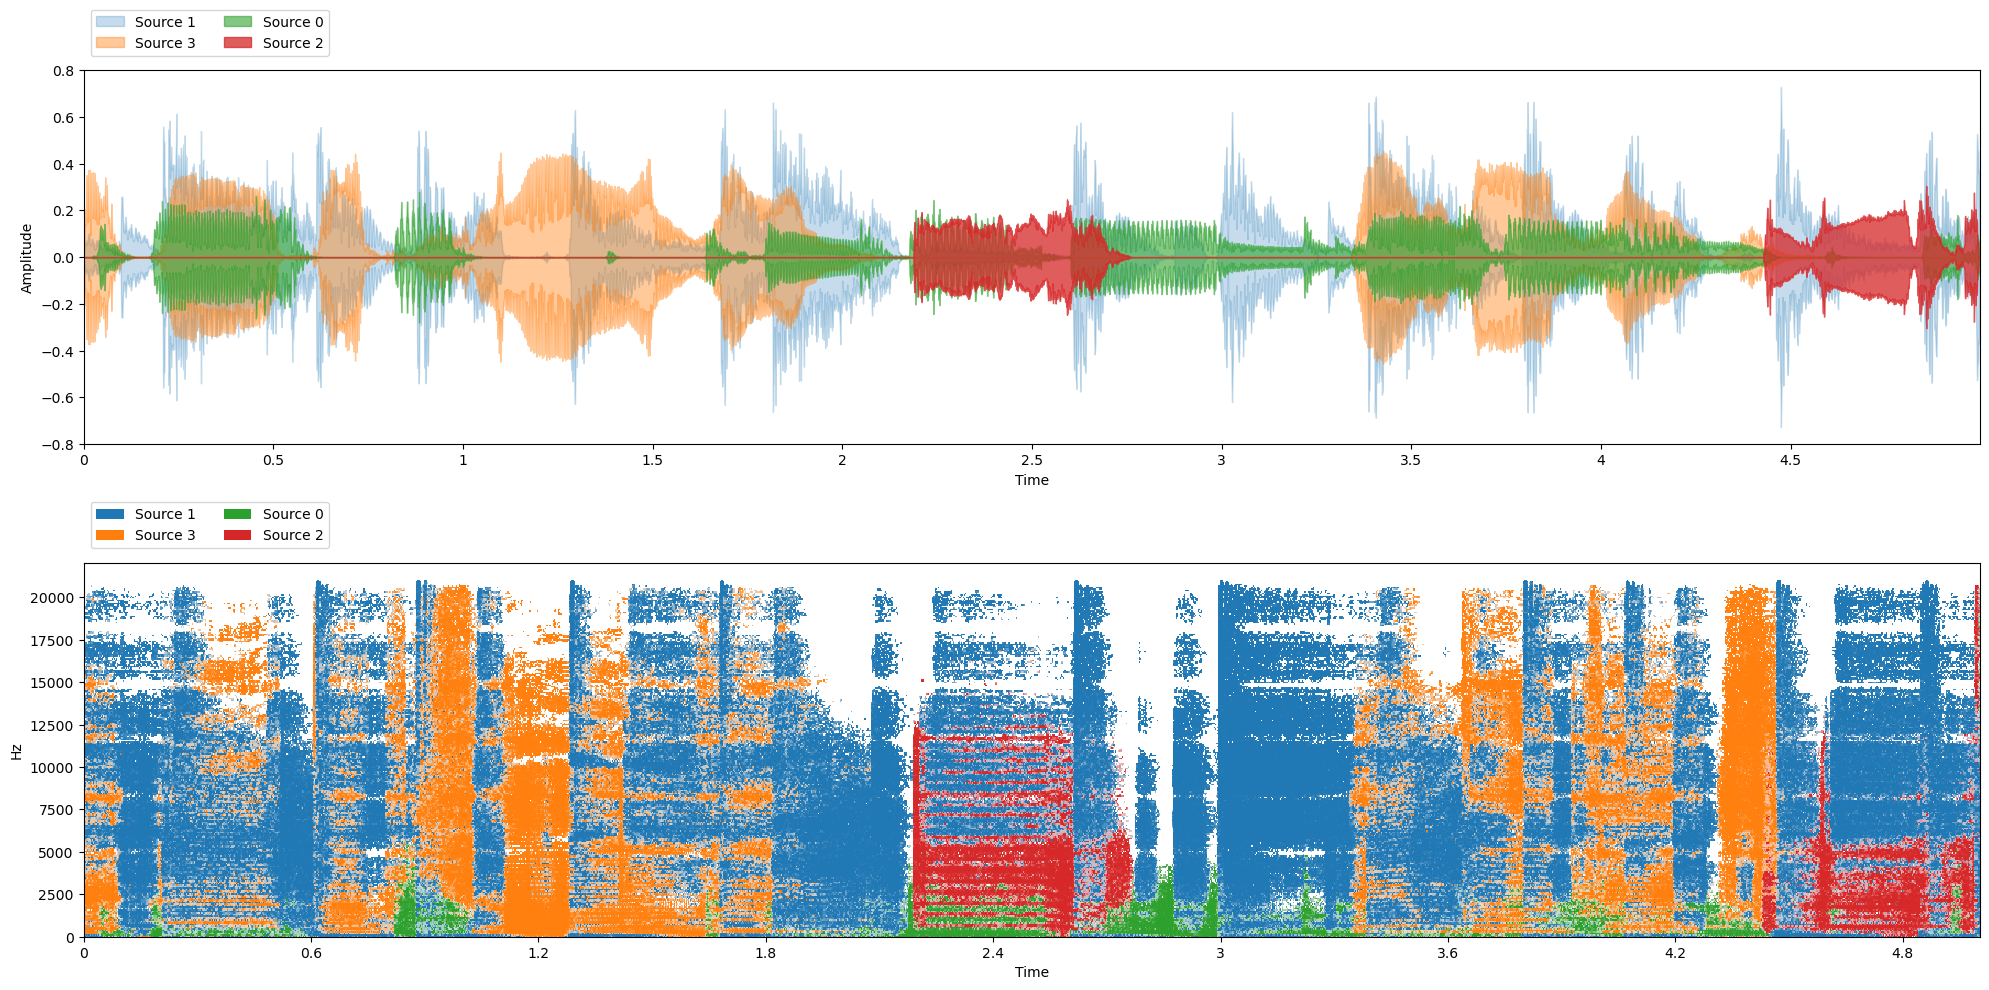


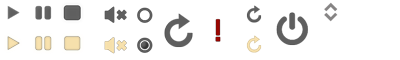
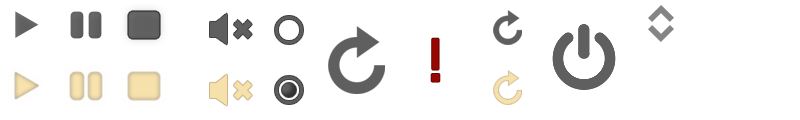
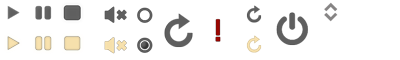

In [86]:
viz.show_sources(ground_truth)

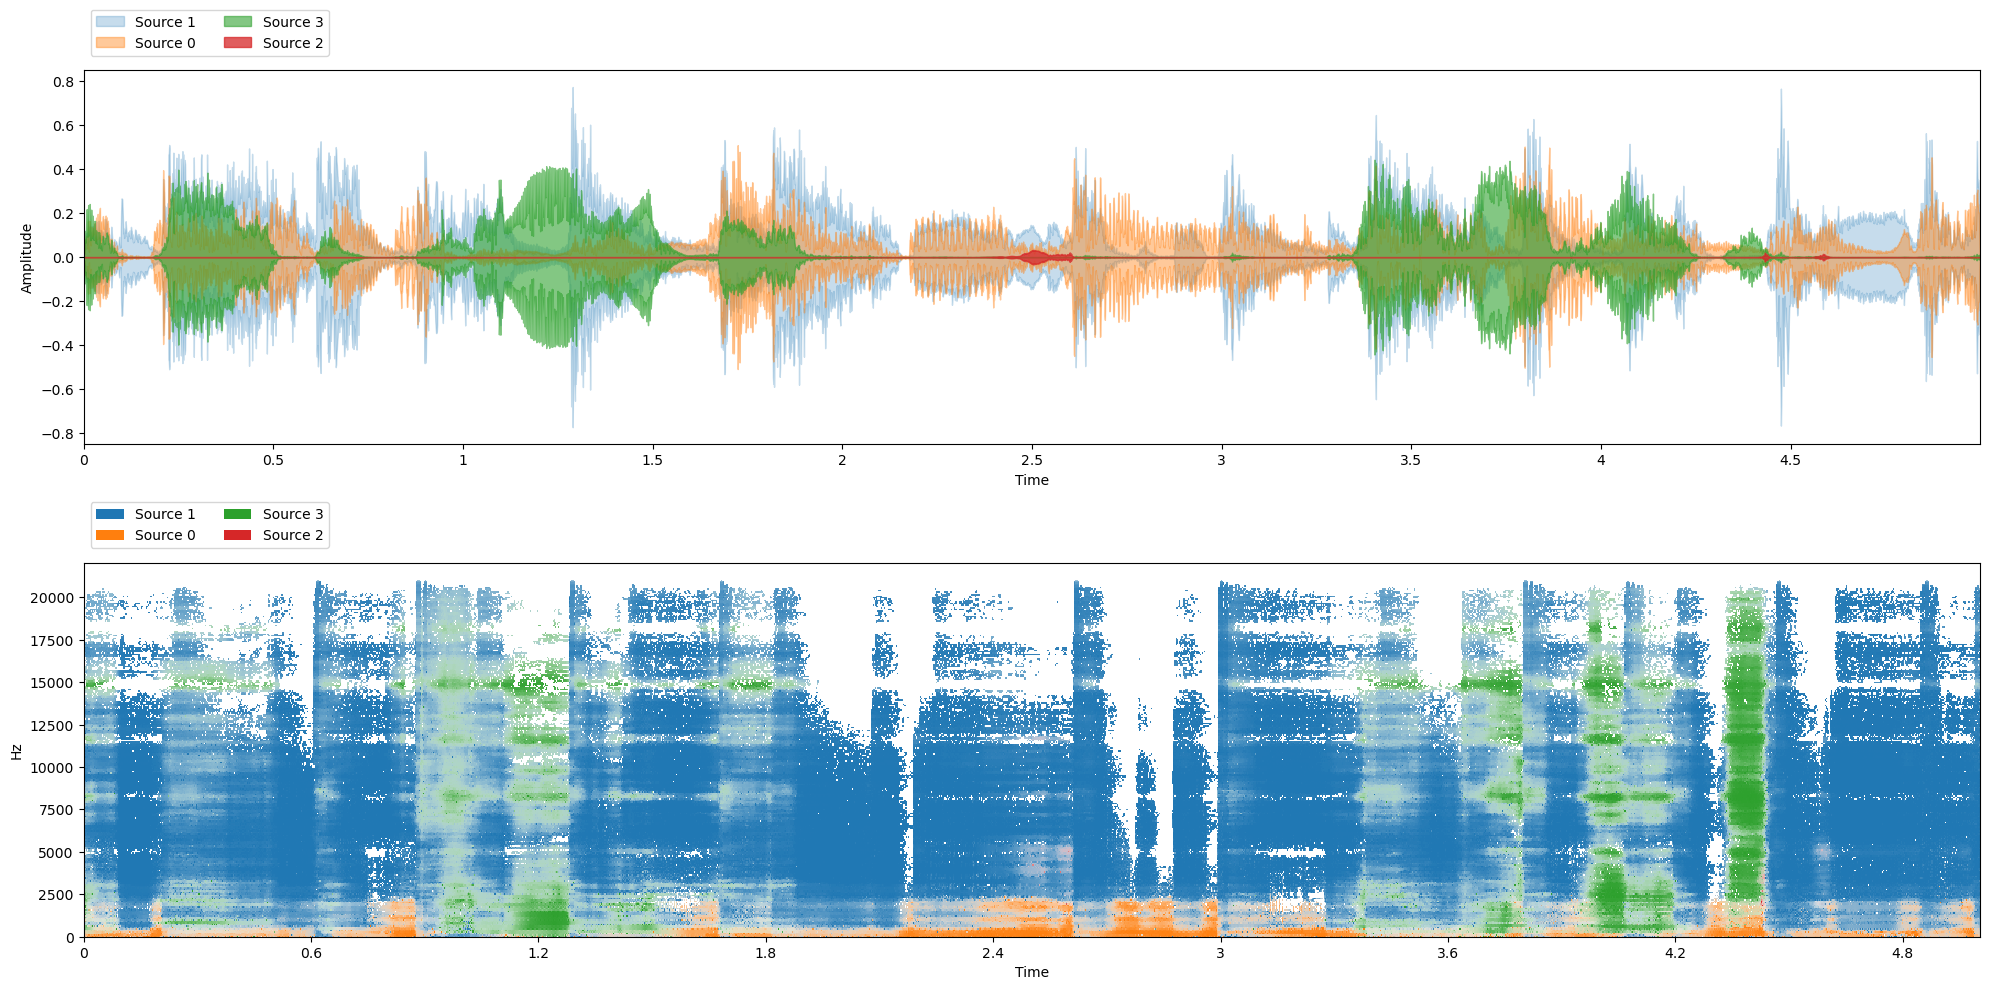


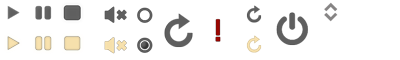
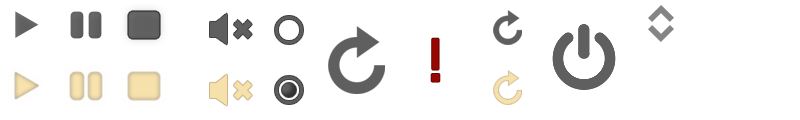
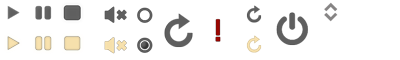

In [87]:
separator.audio_signal = signal
estimates = separator()
viz.show_sources(estimates)